In [1]:
!nvidia-smi

Mon Dec  9 02:52:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              42W / 350W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Dataset

In [2]:
# CIFAR 10 dataset
import torchvision
from torchvision import transforms
custom_transform = transforms.Compose([
    transforms.ToTensor(),
    # -0.5 then /0.5
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
import os
cifar = torchvision.datasets.CIFAR10('./data', download=True, transform=custom_transform)
len(cifar)

100%|██████████| 170M/170M [00:01<00:00, 98.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


50000

In [3]:
import torch
#
dl = torch.utils.data.DataLoader(cifar, batch_size=512, shuffle=False, num_workers=32)
# visualize first batch
x,_ = next(iter(dl))
x.shape, x.min(), x.max()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(torch.Size([512, 3, 32, 32]), tensor(-1.), tensor(1.))

In [4]:
def show_single_image(im):
  assert im.shape == (3, 32, 32)
  im = im.permute(1, 2, 0)
  im = im * 0.5 + 0.5
  from matplotlib import pyplot as plt
  plt.figure(figsize=(2, 2))
  plt.imshow(im)
  plt.axis('off')
  plt.show()

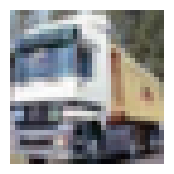

In [5]:
# pick a random data point
data_0 = x[1]
show_single_image(data_0)

# Run our demonstration

In [6]:
CT = 0.2
DT = 0.8

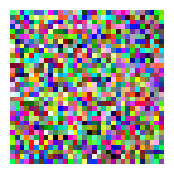

In [7]:
# add noise
noisy = CT * data_0 + DT * torch.randn_like(data_0)
show_single_image(noisy)

In [8]:
# find top3 neighbors
@torch.no_grad()
def nearest_neighbor(x,k=3,ct=CT,dt=DT):
    # x: [3, 32, 32]
    # data: [D, 3, 32, 32]
    assert x.ndim == 3
    x = x.cuda().unsqueeze(0) # [1, 3, 32, 32]
    scores = []
    for _,(data_batch, _) in zip(range(len(dl)),dl):
        data = data_batch.cuda()
        score = -((x.unsqueeze(1)-data.unsqueeze(0)*ct)**2).sum(dim=(-1,-2,-3))/(2*(dt**2)) # [1, D, 3, 32, 32] -> [N, D]
        scores.append(score.cpu())
    weights = torch.cat(scores,dim=1).cuda()
    weights = torch.softmax(weights,dim=-1) # [1, D]
    tpk = torch.topk(weights,k=k,dim=-1)
    inds = tpk.indices # [1, k]
    vals = tpk.values
    images = [cifar[w.item()][0] for w in inds.reshape(-1)] # len k, [3, 32, 32]
    return torch.stack(images), vals.reshape(-1)

first score: 0.9999068975448608


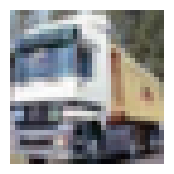

second score: 2.851212957466487e-05


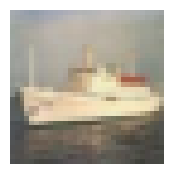

third score: 1.999721825995948e-05


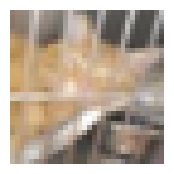

In [9]:
(n1, n2, n3), (s1, s2, s3) = nearest_neighbor(noisy)
print('first score:', s1.item())
show_single_image(n1)
print('second score:', s2.item())
show_single_image(n2)
print('third score:', s3.item())
show_single_image(n3)

In [10]:
print('ratio:', s1.item() / s2.item())

ratio: 35069.52698592363


In [12]:
print('distance 1:', (torch.sqrt(((n1*CT-noisy)**2).sum())).item())
print('distance 2:', (torch.sqrt(((n2*CT-noisy)**2).sum())).item())
print('distance 3:', (torch.sqrt(((n3*CT-noisy)**2).sum())).item())

distance 1: 44.243751525878906
distance 2: 44.394874572753906
distance 3: 44.39999008178711


## Explanation

You can see that the ratio is quite unbalanced (on the order of $10^4$), which matches the explanation in our blog post. Also, the distance themselves doesn't have too much variations, but the probabilities have a very large difference.